# Compute the partition function by tensor contraction

### Some codes in this notebook come from Prof. Pan Zhang's tutorial in summer school.

In [1]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [2]:
import math
import time
from tqdm.auto import trange

In [3]:
import matplotlib.pyplot as plt

---------------------------------
### Chain Cluster

In [4]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grids, dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.float32(beta_init), nb.int8(j_init), nb.int8(h_init)
    grids = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [5]:
dims_init = (4, 4)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [6]:
my_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
global grids, dims, beta, j, h

In [8]:
def node_tensor_create(my_device=my_device):
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B = torch.tensor(sqrtm(np.array([[np.exp(beta*j),np.exp(-beta*j)], 
                                     [np.exp(-beta*j),np.exp(beta*j)]])), 
                     dtype=torch.float64, device=my_device)
    A_1 = torch.einsum("i, ij -> j", [I_1, B])
    A_2 = torch.einsum("ij, ab, jb -> ia", [B, B, I_2])
    A_3 = torch.einsum("ij, kl, mn, jln -> ikm", [B, B, B, I_3])
    A_4 = torch.einsum("ij, kl, mn, pq, jlnq -> ikmp", [B, B, B, B, I_4])
    spin_up = torch.tensor([1, 0], dtype=torch.float64, device=my_device)
    spin_down = torch.tensor([0, 1], dtype=torch.float64, device=my_device)
    spin_up = torch.einsum("i, ij -> j", [spin_up, B])
    spin_down = torch.einsum("i, ij -> j", [spin_down, B])
    return A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [9]:
def copy_tensor_create(my_device=my_device):
    I_2_array = np.zeros((2, 2))
    I_3_array = np.zeros((2, 2, 2))
    I_4_array = np.zeros((2, 2, 2, 2))
    I_up_array = np.zeros((2, 2, 2, 2))
    I_down_array = np.zeros((2, 2, 2, 2))
    for i in range(2):
        I_2_array[i, i] = 1
        I_3_array[i, i, i] = 1
        I_4_array[i, i, i, i] = 1
    I_up_array[0][0][0][0] = 1
    I_down_array[1][1][1][1] = 1
    I_1 = torch.tensor(np.ones((2)), dtype=torch.float64, device=my_device)
    I_2 = torch.tensor(I_2_array, dtype=torch.float64, device=my_device)
    I_3 = torch.tensor(I_3_array, dtype=torch.float64, device=my_device)
    I_4 = torch.tensor(I_4_array, dtype=torch.float64, device=my_device)
    I_up = torch.tensor(I_up_array, dtype=torch.float64, device=my_device)
    I_down = torch.tensor(I_down_array, dtype=torch.float64, device=my_device)
    return I_1, I_2, I_3, I_4, I_up, I_down

In [10]:
global I_1, I_2, I_3, I_4, I_up, I_down

In [11]:
global A_1, A_2, A_3, A_4, B, spin_up, spin_down

In [12]:
def tensors_init(my_device=my_device):
    global I_1, I_2, I_3, I_4, I_up, I_down
    global A_1, A_2, A_3, A_4, B, spin_up, spin_down
    global tensors_list
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    A_1, A_2, A_3, A_4, B, spin_up, spin_down = node_tensor_create(my_device)
    tensors_list = [A_4 for _ in range(dims[1])]

In [13]:
def tensors_list_prepare(grids, row_id):
    row_id_up = (row_id - 1) % dims[0]
    row_id_down = (row_id + 1) % dims[0]
    up_bdy_vector_list = [spin_up if grids[row_id_up][i] == 1 else spin_down 
                          for i in range(dims[0])]
    down_bdy_vector_list = [spin_up if grids[row_id_down][i] == 1 else spin_down 
                            for i in range(dims[0])]
    tensors_list = []
    for i in range(dims[1]):
        tensor_i = torch.einsum("ijkl, j, l -> ik", [A_4, 
                                                     down_bdy_vector_list[i],
                                                     up_bdy_vector_list[i]])
        tensors_list.append(tensor_i)
    return tensors_list, up_bdy_vector_list, down_bdy_vector_list

In [45]:
def chain_one_row(grids, row_id):
    tensors_list, up_bdy_vector_list, down_bdy_vector_list = tensors_list_prepare(grids, row_id)
    start_id = 0
    end_id = dims[1] - 1
    up_row_id = (row_id - 1) % dims[0]
    down_row_id = (row_id + 1) % dims[0]
    #########################################################
    spin_up_bdy = up_bdy_vector_list[start_id]
    spin_down_bdy = down_bdy_vector_list[start_id]
    B_up = torch.einsum("ij, j -> i", [B, spin_up_bdy])
    B_down = torch.einsum("ij, j -> i", [B, spin_down_bdy])
    #########################################################
    tensor_start = tensors_list[start_id+1]
    #tensor_start = torch.einsum("ij, jk -> ik", [B, tensor_start])
    tensors_stack = [tensor_start]
    for i in range(2, dims[1]):
        tensor_start = torch.einsum("ij, jk -> ik", [tensor_start, 
                                                     tensors_list[i]])
        tensors_stack.append(tensor_start)
    z_four_edge = torch.einsum("in, nj, jk, l, m -> iklm", [B, tensor_start,
                                                            B, B_up, B_down])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up]) 
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])                         
    z = z_up + z_down
    #print(z)
    prob_up = z_up / z
    prob_random = np.random.random()
    if prob_random < prob_up:
        grids[row_id][start_id] = 1
    else:
        grids[row_id][start_id] = -1
    return tensors_stack, grids, z, up_bdy_vector_list, down_bdy_vector_list

In [46]:
def backtrack(grids, start_id, row_id, tensors_stack, 
              up_bdy_vector_list, down_bdy_vector_list):
    tensors_stack.pop()
    left_bdy = spin_up if grids[row_id][start_id] == 1 else spin_down
    for i in range(dims[1]-2):
        right_bdy = spin_up if grids[row_id][start_id] == 1 else spin_down
        start_id = (start_id - 1) % dims[1]
        down_bdy, up_bdy = down_bdy_vector_list[start_id], up_bdy_vector_list[start_id]
        start_tensor = tensors_stack.pop()
        z_four_edge = torch.einsum("i, ij, jl, om, o, pn, p, rk, r -> lmnk", 
                                   [left_bdy, start_tensor, B, B,
                                    up_bdy, B, down_bdy, B, right_bdy])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        z = z_up + z_down
        #print(z)
        prob_up = z_up / z
        prob_random = np.random.random()
        if prob_random < prob_up:
            grids[row_id][start_id] = 1
        else:
            grids[row_id][start_id] = -1
    up_bdy, down_bdy = up_bdy_vector_list[start_id-1], down_bdy_vector_list[start_id-1]
    #print(up_bdy)
    #print(down_bdy)
    right_bdy = spin_up if grids[row_id][start_id] == 1 else spin_down
    #print(right_bdy)
    z_four_edge = torch.einsum("i, j, k, l, im, jn, ko, lp -> mnop", [up_bdy, down_bdy,
                                                                      left_bdy, right_bdy,
                                                                      B, B, B, B])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    #print(z)
    prob_up = z_up / z
    prob_random = np.random.random()
    if prob_random < prob_up:
        grids[row_id][start_id-1] = 1
    else:
        grids[row_id][start_id-1] = -1    
    return grids  

In [16]:
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibors_get((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [17]:
types_neibor_get_triangle_func = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get_triangle_func)
def neibor_get_square(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)
    return (l_neibor, r_neibor, u_neibor, d_neibor)

In [18]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibor_get_square((nb.int8(ii), nb.int8(jj)))
            for ij in id_neibors:
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [19]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m_mean = np.mean(grids)
    return m_mean

In [20]:
def chain_sampling_one_step(grids):
    start_id = 0
    for i in range(dims[0]):
        tensors_stack, grids, _, up_bdy_list, down_bdy_list = chain_one_row(grids, i)
        grids = backtrack(grids, start_id, i, tensors_stack, up_bdy_list, down_bdy_list)
    return grids         

In [21]:
def chain_evolution(grids, num_steps):
    energy_history = []
    m_history = []
    for _ in trange(num_steps):
        grids = chain_sampling_one_step(grids)
        energy_per_spin = energy_compute_grids(grids)
        m_per_spin = magnet_grids(grids)
        energy_history.append(energy_per_spin)
        m_history.append(m_per_spin)
    return grids, energy_history, m_history

In [33]:
### function used to check the chain evolution
def chain_message_passing(grid, id_row, id_start, id_end):
    id_up_row = (id_row - 1) % dims[0]
    id_down_row = (id_row + 1) % dims[0]
    left_id = (id_start - 1) % dims[1]
    energy_up = -j * (grid[id_up_row][id_start] + grids[id_row][left_id] + grids[id_down_row][id_start])
    energy_down = -1 * energy_up
    infor_node = np.exp([-beta * energy_up, -beta * energy_down])
    infor_edge = np.exp([[beta, -beta], [-beta, beta]])
    for i in range(id_start+1, id_end+1):
        energy_up_i = -j * (grid[id_up_row][i] + grids[id_down_row][i])
        energy_down_i = -1 * energy_up_i
        infor_node_orig = np.exp([-beta * energy_up_i, -beta * energy_down_i])
        infor_node = np.dot(infor_node, infor_edge)
        infor_node = infor_node * infor_node_orig
    if (id_end + 1) == dims[1]:
        energy_up_end = -j * grid[id_row][0]
    else:
        energy_up_end = -j * grid[id_row][id_end+1]
    energy_down_end = -1 * energy_up_end
    infor_node_end = np.exp([-beta * energy_up_end, -beta * energy_down_end])
    infor_node = infor_node * infor_node_end
    z = np.sum(infor_node)
    return infor_node, z

In [23]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grids*np.pi/2)
    v = np.sin(grids*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

## Test part

In [24]:
dims_init = (4, 4)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [38]:
tensors_init()

In [39]:
row_id = 0

In [40]:
tensors_list, up_bdy_list, down_bdy_list = tensors_list_prepare(grids, row_id)

In [41]:
tensors_stack, grids, z, _, _ = chain_one_row(grids, row_id)

In [42]:
backtrack(grids, 0, row_id, tensors_stack, 
          up_bdy_list, down_bdy_list)

tensor(20.9706, dtype=torch.float64)
tensor(11.1430, dtype=torch.float64)
tensor(2.8284, dtype=torch.float64)


array([[ 1,  1,  1,  1],
       [-1, -1,  1,  1],
       [ 1,  1,  1,  1],
       [-1,  1,  1, -1]], dtype=int8)

In [43]:
id_start = 1
id_end = dims[1]
z_list = []
for i in range(id_start+1, id_end):
    _, z = chain_message_passing(grids, row_id, id_start, i)
    z_list.append(z)

In [44]:
z_list

[11.143003419832993, 20.97056336090631]

---------------------------
### Size = 4

In [47]:
dims_init = (4, 4)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
#beta_init, j_init, h_init = 10, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [48]:
tensors_init()

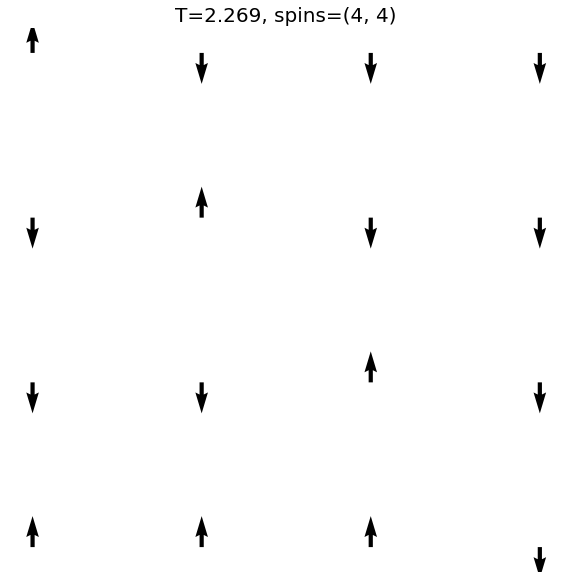

In [49]:
spin_viz()

In [50]:
### Burning-in stage
time_start = time.time()
num_steps = 10000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 227.69837927818298.


In [52]:
np.mean(np.abs(np.array(m_history)))

0.84495

In [47]:
### Sampling stage
time_start = time.time()
num_steps = 100000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/100000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 553.4767985343933.


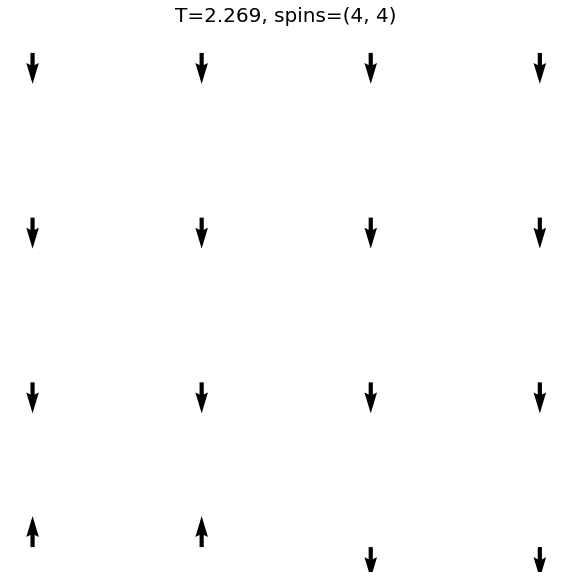

In [34]:
spin_viz()

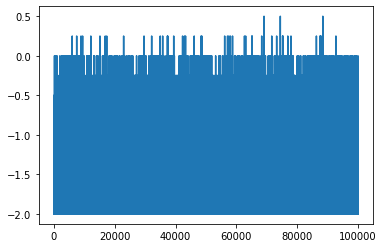

In [96]:
plt.plot(energy_history)

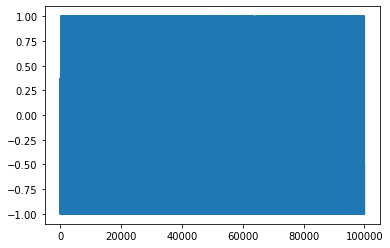

In [97]:
plt.plot(m_history)

In [98]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.84354125.


------
#### Size = 8

In [25]:
dims_init = (8, 8)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
#beta_init, j_init, h_init = 0.01, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [26]:
tensors_init()

In [27]:
### Burning-in stage
time_start = time.time()
num_steps = 100000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/100000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 2905.0478224754333.


In [28]:
m_abs_mean = np.mean(np.abs(m_history))

In [29]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.7780775.


-------
### Size = 16

In [30]:
dims_init = (16, 16)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
#beta_init, j_init, h_init = 0.01, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [31]:
tensors_init()

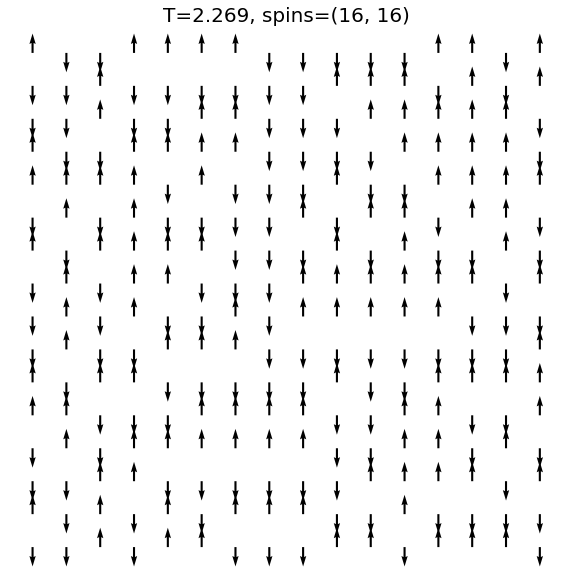

In [32]:
spin_viz()

In [35]:
### Burning-in stage
time_start = time.time()
num_steps = 10000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E4 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 1236.3663046360016.


In [37]:
### Burning-in stage
time_start = time.time()
num_steps = 10000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E4 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 1165.0116691589355.


In [38]:
m_abs_mean = np.mean(np.abs(m_history))

In [39]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.70499609375.


-----
### Size = 32

In [43]:
dims_init = (32, 32)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0 
#beta_init, j_init, h_init = 0.01, 1, 0 
parameters_init(dims_init, beta_init, j_init, h_init)

In [44]:
tensors_init()

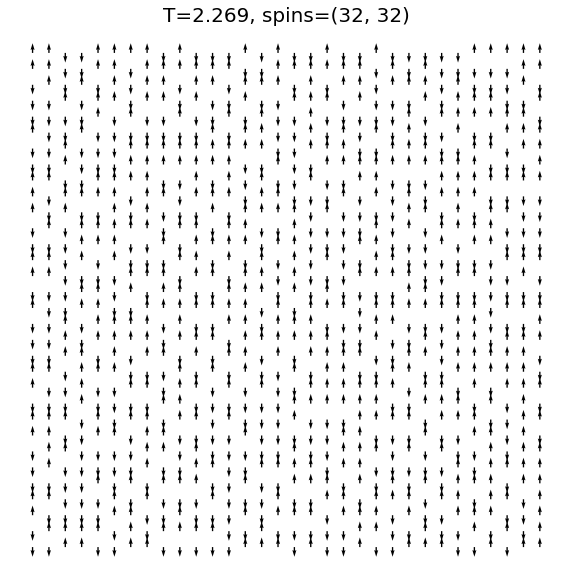

In [45]:
spin_viz()

In [46]:
### Burning-in stage
time_start = time.time()
num_steps = 10000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 4639.791697025299.


In [47]:
### Sampling stage
time_start = time.time()
num_steps = 10000
grids, energy_history, m_history = chain_evolution(grids, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 4645.274792432785.


In [48]:
m_abs_mean = np.mean(np.abs(m_history))

In [49]:
m_abs_mean = np.mean(np.abs(m_history))
print(f"The magnitization is: {m_abs_mean}.")

The magnitization is: 0.643087109375.


----------
### Summary

In [50]:
size_array = np.array([4, 8, 16, 32])
m_abs_array = np.array([0.84354125, 0.7780775, 0.70499609375, 0.643087109375])

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice (J > 0)')

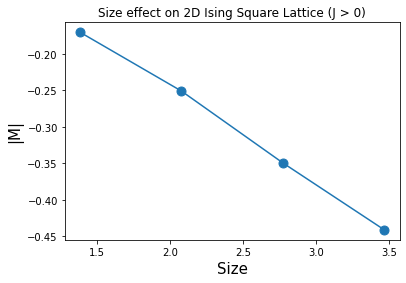

In [51]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(m_abs_array), '-o', markersize=9)
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice (J > 0)")